This script takes land use data for the municipality of Belo Horizonte and regroups the original categories into simpler, more aggregate categories. The level of disaggregation present in the original data not only is unnecessary, for the purposes of the Thesis, but it would add up to a higher level of complications and noise, not the mention the more elevated computational costs.

Then, land use geometries are parsed into a grid of Uber's H3 Hexagons of resolution that is akin to the area of the median parcel in belo Horizonte municipality. These hexagons also contain populational counts and income as per the 2010 Census.

The script has at first been written with the 2017 land use map, which was readily available online. Afterwards, the years 2011, 2018, and 2020 maps are parsed into hexagons using the same functions but with some minor tunings.

# Land Use Maps for 2017

In [1]:
import os
import pathlib

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from h3census.assemble import get_hexagons_with_census_data
from matplotlib.patches import Patch

%matplotlib inline
%config InlineBackend.figure_format='retina'

## Preliminaries

### Parent Folders

These should of course be adjusted to reflect the appropriate locations in your disk or wherever

In [2]:
out_folder = os.environ.get('OUT_FOLDER')
out_folder = pathlib.Path(out_folder)
out_folder = out_folder / 'A'

db_folder = os.environ.get('DB_FOLDER')
db_folder = pathlib.Path(db_folder)

### General Purpose

In [3]:
def _get_zipped_path_for_gpd(path):
    """This gets a full path for a zipped shp file and parses it
    into a structure that gpd.read_file() understands.
    """
    prefix = r'zip://'
    
    try:
        path = prefix + path.as_posix()
    except:
        path = pathlib.PureWindowsPath(path)
        path = prefix + path.as_posix()
        
    return path

## Getting Land Use Data

data source: http://bhmap.pbh.gov.br

In [4]:
def get_geodata(path, is_zipped=True):
    """Takes either a full raw string path os a pathlib's pure windows
    path and uses it to return a shapefile. It also makes the necessary
    adjustments to read shapefiles compressed into a .zip file.
    """    
    if is_zipped:
        path = _get_zipped_path_for_gpd(path)
            
    return gpd.read_file(path)

## Initial Exploration and Preliminary Wrangling

In [5]:
path = db_folder / 'beaga/tipologia_uso_ocupacao/uso_ocup_2017.zip'

land_uses = get_geodata(path)

# some later operations don't handle well a mix of Polygons and MultyPolygons
land_uses = land_uses.explode()
land_uses.reset_index(drop=True, inplace=True)

In [6]:
land_uses.head(2)

ID_TP_USO_      NULOTCTM   TIPOLOGIA_        TIPOLOGIA0  \
0    304274.0  091029400040  RESIDENCIAL  casa unifamiliar   
1    304275.0  091029400030        MISTO      casa/sobrado   

                                            geometry  
0  POLYGON ((607797.123 7793915.752, 607787.343 7...  
1  POLYGON ((607808.568 7793920.691, 607797.444 7...

In [7]:
print(land_uses.crs)

epsg:31983


In [8]:
new_names = {'TIPOLOGIA_': 'type', 'TIPOLOGIA0': 'category'}
land_uses.rename(columns=new_names, inplace=True)

to_keep = ['type', 'category', 'geometry']
land_uses = land_uses.reindex(columns=to_keep)

del new_names, to_keep

In [9]:
number_of_parcels = len(land_uses)
land_uses['type'].value_counts() / number_of_parcels * 100

RESIDENCIAL                  60.464682
MISTO                         7.835141
LOTE VAGO                     7.821213
NAO RESIDENCIAL               7.199762
RESIDENCIAL+LOTE VAGO         0.466019
NAO RESIDENCIAL+LOTE VAGO     0.224792
MISTO + LOTE VAGO             0.100279
Name: type, dtype: float64

In [10]:
land_uses.category.value_counts() / number_of_parcels * 100

casa unifamiliar                                 54.869108
sem informacao                                   15.712622
casa/sobrado                                      6.197528
lote vago                                         4.514231
edificio                                          4.461028
loja ou conjunto de lojas                         4.080803
galpao                                            3.369100
edificação sem tipologia especificada             3.149600
conjunto multifamiliar vertical                   1.426749
edificio residencial e comercio e/ou servicos     0.711703
edificio de uso comercial e/ou servicos           0.468805
parque                                            0.345684
instituicao de ensino                             0.147355
loja em edificio/galeria                          0.111143
conjunto multifamiliar horizontal                 0.104736
ocupação diversificada                            0.084402
industria                                         0.0523

**The regrouping of land uses aims at reducing the number of categories by bringing together like things that are apart for some reason. The rationale below refers to the 2017 land use map and it might (and probably will) be at least slightly different for the other years.**

- Most instances are straightforward, such as 'casa unifamiliar', for example, which clearly is residential; or such as 'edificio de uso comercial e/ou servicos' which is obviously retail/services.

- There were cases in which discordant classifications were residual. Hence, the residuals have been put together along with the majority class. For example, there are 6 mixed use parcels of 'edificio' amidst a sea of 16009 residential parcels.

- Mixed uses presented a difficulty as well because the classical model deals with discrete classifications only. There are models that allow for some fuzzy classification, which means that a cell can go from fully residential to completely commercial, while being able to assume any percentual balance in between those extremes. Unfortunatelly, to the best of my knowledge, such models seem still incipient and displaying some perks that I don't think are for me to solve (at least not now). Hence, I chose to create a 'mixed' category and leave it at that. After some future experimentations, I might choose to place it either under retail/services or under residential.

- All parcels containing any kind of (a) club or public goods, and of (b) public facilities, amenities or infrastructures have been considered static and are all labeled as ***public***

- 'edificação sem tipologia especificada' was assumed to be residential, because:
    - For any given lot, the highest probability is that it is residential;
    - In the brazilian context, there is plenty of illegal land ocupation due to favelas and whatnot;
    - I assumed it is harder for commercial activity to function without registry in the tax records.
    
**A minor number of instances require a slightly more detailed analysis, which here means that a proper reclassification required a simultaneous analysis of 'type' and 'category' attributes. Specifically:**

- There are two land use categories that are unclear in of themselves ('ocupação diversificada', 'vaga residencial ou comercial') these have been classified with the aid of _reclassify_with_scrutiny() function.

- 'galpao' at first seemed obviously related to the industrial sector, but a closer look at its spatial distribution, along with a couple checks in Google maps, made it seem otherwise. It did not seem, for the most part, related to heavy industry, specially the parcels of this category that were placed within the city's core and along its major roads. Hence, for the time being, it was placed under either retail/services or mixed, until some later analysis reveals otherwise, if such a thing is revealed at all. The choice between mixed and retail/services is made within _reclassify_with_scrutiny().

**Finally, the following category required a method that was a bit more thorough:**

- 'sem informacao' refers to all parcels without registry at the municipal treasury. To gain better insight, I performed a quick and coarse visual inspection with the aid of (a) OpenStreetMaps, (b) Google Maps, and (c) other auxilliary data. That seemed to support the reasoning that this category could be divided thus:
    - First, parcels are evaluated against the 2018 urban footprint: those that are not completely contained within the footprint are considered vacant land. The year 2018 was chosen because its the closest year available that was found at the time of wrting.
    - Second, there are parcels that mostly coincide with the footprints of the subnormal agglomerates - see note below -  in the municipality, as per data retrieved both at IBGE and at Belo Horizonte City Hall. Those are to be labeled subnormal, but probably will be joined together with residential in a later step of the analysis.
    - Third, the majority of the remaining parcels seem to fit under the label ***public***, so whatever doesn't fit in the two above conditions will be named public without further analysis, as I don't see a way around that does not involve checking one by one. 


**NOTE:**

A subnormal agglomerate is a form of irregular occupation of land – either public or private - owned by a third party, for housing purposes in urban areas, usually characterized by an irregular urban pattern, with scarce essential public services and located in areas not proper or allowed for housing use.  In Brazil, those irregular settlements are known by the names of favelas, invaded areas, slums in deep valleys, slums in low-lands, communities, villages, slums in backwaters, irregular lots, shacks and stilt houses

In [11]:
regrouping_2017 = {
    'active': {
        'residential': ['casa unifamiliar',
                        'edificio', 
                        'conjunto multifamiliar vertical',
                        'conjunto multifamiliar horizontal',
                        'edificação sem tipologia especificada',],
        
        'retail/services': ['loja ou conjunto de lojas',
                            'edificio de uso comercial e/ou servicos',
                            'loja em edificio/galeria',
                            'shopping center',
                            'galeria/mini shopping de bairro',
                            'apart hotel',],
        # TO DO: settle approach towards mixed uses
        'mixed': ['casa/sobrado',
                  'edificio residencial e comercio e/ou servicos',]
                },

     'passive': { 
         'vacant': ['lote vago',]
                 },

     'static': {
         'industry': ['industria',],
         
         'public': ['instituicao de ensino',
                    'equipamento de saude',
                    'instituicao religiosa',
                    'cemiterio',
                    'parque',
                    'clubes esportivos e sociais',
                    'estadio/ginasio',
                    'aterro sanitario',
                    'estacao de transporte coletivo',
                    'aeroporto',],
               }
}

In [12]:
def _reclassify_with_scrutiny(gdf):
    """Deals with some perks that seem too specific for generalization.
    Handles instances in which TIPOLOGIA0 may be more accurately placed
    when analyzed together with TIPOLOGIA_
    
    NOTE: function's name is an exaggeration
    """
    # 'ocupação diversificada'
    # ----------------------
    mask_a = gdf.category=='ocupação diversificada'
    mask_b = gdf['type'].isin(['RESIDENCIAL', 'RESIDENCIAL+LOTE VAGO'])
    mask_c = gdf['type'].isin(['MISTO', 'MISTO + LOTE VAGO'])
    
    full_mask = mask_a & mask_b
    gdf.loc[full_mask,'category'] = 'residential'
    
    full_mask = mask_a & mask_c
    gdf.loc[full_mask,'category'] = 'mixed'
    
    full_mask = mask_a & (~mask_b) & (~mask_c)
    gdf.loc[full_mask,'category'] = 'retail/services'
    
    # 'vaga residencial ou comercial'
    # -----------------------------
    mask_d = gdf.category=='vaga residencial ou comercial'
    mask_e = gdf['type']=='NAO RESIDENCIAL'
    mask_f = gdf['type']=='RESIDENCIAL'
    
    full_mask = mask_d & mask_e
    gdf.loc[full_mask,'category'] = 'retail/services'
    
    full_mask = mask_d & mask_f
    gdf.loc[full_mask,'category'] = 'residential'
    
    full_mask = mask_d & (~mask_e) & (~mask_f)
    gdf.loc[full_mask,'category'] = 'mixed'
    
    # 'galpao'
    # ------
    # TO DO: assert if this decision is appropriate
    mask_g = gdf.category=='galpao'
    
    full_mask = mask_g & mask_c
    gdf.loc[full_mask,'category'] = 'mixed'
    
    full_mask = mask_g & (~mask_c)
    gdf.loc[full_mask,'category'] = 'retail/services'
    
    # 'Final adjustment'
    # ----------------
    cat_list = ['residential', 'retail/services', 'mixed', 'galpao']
    gdf.loc[gdf.category.isin(cat_list), 'type'] = 'active'
    

def reclassify_land_uses(gdf, dictionary):
    _reclassify_with_scrutiny(gdf)
    for key in dictionary.keys():
        for umbrella_category,old_categories in dictionary[key].items():
            mask = gdf.category.isin(old_categories)
            gdf.loc[mask, 'type'] = key
            
            replacement_dict = {
                cat: umbrella_category
                for cat
                in old_categories
                                }
            view = gdf.loc[mask,'category']
            gdf.update(view.replace(replacement_dict))

In [13]:
reclassify_land_uses(land_uses,
                     regrouping_2017,)

In [14]:
path_to_footprint = (db_folder
                     / 'beaga'
                     / 'footprints'
                     / '2018_footprint.zip')
footprint_2018 = get_geodata(path_to_footprint)

In [15]:
# BH city hall uses the term favelas for the subnormal agglomerates
path_to_favelas = (db_folder
                   / 'beaga'
                   / 'vila_favela.zip')
favelas = get_geodata(path_to_favelas)

footprint and favela data:
   - BH Maps: http://bhmap.pbh.gov.br

In [16]:
path_to_subnormal = (db_folder
                     / 'census'
                     / '2010_subnormal_agglomerates'
                     / 'SetoresXAreaDivAGSN_shp.zip') 
subnormal_agg = get_geodata(path_to_subnormal)

# IBGE data provides all census tracts of Brazil and
# specifies which are subnormal, so that we need to
# slice the dataset.
#
# First we select only census tracts of BH city. To do
# that end we take advantage of the fact the tract IDs 
# contain the city ID they belong to.
#
# Second, we use the appropriate column to select the
# subnormal places.
subnormal_agg = subnormal_agg.loc[subnormal_agg
                                  .CD_GEOCODI
                                  .str
                                  .match('3106200')] # ibgeID for BH

subnormal_agg = subnormal_agg.loc[subnormal_agg
                                  .Subnormal == 'Sim']

# IBGE data comes in a geographic coordinate system
# that needd to be projected to the same CRS as
# Belo Horizonte's data
subnormal_agg.to_crs(epsg=31983, inplace=True)

In [17]:
subnormal = gpd.overlay(subnormal_agg,
                        favelas,
                        how='union')

data on subnormal agglomerates:

- IBGE: ftp://geoftp.ibge.gov.br/recortes_para_fins_estatisticos/malha_de_aglomerados_subnormais/censo_2010/areas_de_divulgacao_da_amostra/

use sjoin - within to finde who is outside the footprint

Perform the union of favelas with subnormal
use GeoSeries.intersects to find out parcels that touch subnormal agglomerates


once these are done, it should be possible to classify the leftovers by elimination

remember to use functions, as this is to be repeated at least for 2011

compute how much of sem informacao goes to each subcategory 


In [18]:
def _find_vacant(parcels, footprint):
    inner_parcels = gpd.sjoin(parcels,
                              footprint,
                              how='inner',
                              op='within',)
    inner_parcel_ids = inner_parcels.index
    
    vacant_land = parcels.loc[~parcels
                              .index
                              .isin(inner_parcel_ids)]
    
    
    return vacant_land.index


def _reclassify_vacant(parcels, vacant_land):    
    parcels.loc[vacant_land, 'type'] = 'passive'
    
    mask = parcels.index.isin(vacant_land)
    parcels.loc[mask,'category'] = 'vacant'


def _find_subnormal(parcels, subnormal):
    subnormal_land = gpd.sjoin(parcels,
                               subnormal,
                               op='intersects',)
    
    
    return subnormal_land.index


def _reclassify_subnormal(parcels, subnormal_land):    
    parcels.loc[subnormal_land, 'type'] = 'active'
    
    mask = parcels.index.isin(subnormal_land)
    parcels.loc[mask, 'category'] = 'subnormal'
    
    
def _reclassify_leftovers(parcels, mask):
    parcels.loc[mask, 'type'] = 'static'
    parcels.loc[mask, 'category'] = 'public'


def reclassify_untaxed_parcels(parcels, footprint, subnormal, untaxed_cat):
    vacant_land = _find_vacant(parcels, footprint)
    _reclassify_vacant(parcels, vacant_land)
    
    subnormal_land = _find_subnormal(parcels, subnormal)
    _reclassify_subnormal(parcels, subnormal_land)
    
    submask_a = (parcels['category'] == untaxed_cat)
    submask_b = (~parcels.index.isin(vacant_land))
    submask_c = (~parcels.index.isin(subnormal_land))
    mask = (submask_a & submask_b & submask_c)
    _reclassify_leftovers(parcels, mask)
    

In [19]:
reclassify_untaxed_parcels(land_uses,
                           footprint_2018,
                           subnormal,
                           'sem informacao',)

In [20]:
number_of_parcels = len(land_uses)
land_uses['type'].value_counts() / number_of_parcels * 100

active     88.626956
static      6.336804
passive     5.036240
Name: type, dtype: float64

In [21]:
land_uses.category.value_counts() / number_of_parcels * 100

residential        62.024580
subnormal          11.850484
mixed               7.689458
retail/services     7.062435
public              6.286107
vacant              5.036240
industry            0.050697
Name: category, dtype: float64

In [22]:
def get_hexagon_edge(land_uses):
    """Computes the edge of an hexagon with the same area as that
    of the median parcel. Requires projected CRS.
    """
    land_parcel_areas = land_uses.geometry.map(lambda x: x.area)
    median_area = np.median(land_parcel_areas)
    
    
    return np.sqrt(median_area*2/(3*np.sqrt(3)))


mask = land_uses['type'] != 'static'
hex_edge = get_hexagon_edge(land_uses.loc[mask])
print(f'Hex edge should be of approximately {hex_edge:.2f} meters')

Hex edge should be of approximately 11.81 meters


That leaves either H3 resolution 11 (edge length of approx. 25m) or resolution 12 (~9.5m) — _refer to https://h3geo.org/docs/core-library/restable/ for H3 resolutions_

_**Resolution 11**_ seems close enough and it's most certainly better for processing purposes. This resolution will be the basis for all subsequent analysis in the other scripts.



## Retrieving Hexagons

Those are to be the main spatial unit of analysis throughout the Thesis

In [23]:
state = 31 # MG ID as int
ibgeID = '3106200' # Belo Horizonte ID as str
                   # TO DO: allow ibgeID as int as well
hexagon_size = 11

path_to_census = (db_folder
                  / 'census'
                  / '2010 Universo'
                  / '2010_aggregates_by_enumeration_area.csv')

usecols = {
    'v002': 'pop',
    # Average income of all those who are 10 years
    # or older and earn wages of some sort
    'v011': 'income',
         }

# TO DO: allow for 'area_weighted_vars' and
# 'pop_weighted_vars' not to be lists
hexagons = get_hexagons_with_census_data(state,
                                         ibgeID,
                                         hexagon_size,
                                         usecols,
                                         area_weighted_vars=['pop'],
                                         query_data=False,
                                         save_query=False,
                                         path=path_to_census,
                                         pop_col='pop',
                                         pop_weighted_vars=['income'],
                                         output_epsg=31983,)

Sanity check:
 141424 H3 labels, with resolution 11,  after dropping 0 duplicates


In [24]:
def input_uses_into_hex(land_uses, hexagons):
    """This goes hexagon by hexagon, checks what land
    uses are contained within and assigns to the entire
    hexagon the land use that ocupies most of the area.
    
    TO DO: this smells of inneficiency. Think of another way later
    """
    # I used reset index method in hexagons as a way to
    # retain hexagon labels after overlay
    overlay = gpd.overlay(land_uses,
                          hexagons.reset_index(),
                          how='intersection',)
    hex_land_uses = {}
    for hex_label,group in overlay.groupby(f'{hexagons.index.name}'):
        gdf = group.dissolve(by='category', aggfunc='first')
        gdf['area'] = gdf.geometry.map(lambda x: x.area)
        # Mind that gdf is indexed by 'category' because of dissolve
        idxmax = gdf.area.idxmax()
        hex_land_uses[hex_label] = {'type': gdf.loc[idxmax, 'type'],
                                    'category': idxmax,}
    
    
    return pd.DataFrame.from_dict(hex_land_uses, orient='index')
    
    
hex_land_uses = input_uses_into_hex(land_uses, hexagons)

In [25]:
hex_ = hexagons.merge(hex_land_uses,
                      how='inner',
                      left_index=True,
                      right_index=True,)

In [26]:
path_to_hexes = out_folder / f'BH_hex_{hexagon_size}_with_land_uses.gpkg'

hex_.to_file(path_to_hexes, layer='2017', driver='GPKG')

In [27]:
def plot_land_uses(parcels, attribute, palette, ax):
    legend_elements = []
    for cat, group in parcels.groupby(attribute):
        color = palette[cat]

        group.plot(ax=ax,
                   color=color,)

        patch_element = Patch(facecolor=color,
                              edgecolor=color,
                              label=cat,)

        legend_elements.append(patch_element)

    ax.legend(handles=legend_elements,
              bbox_to_anchor=(1, 0.01),
              loc='lower right',
              prop={'size': 4},)
    
    ax.axis('off')

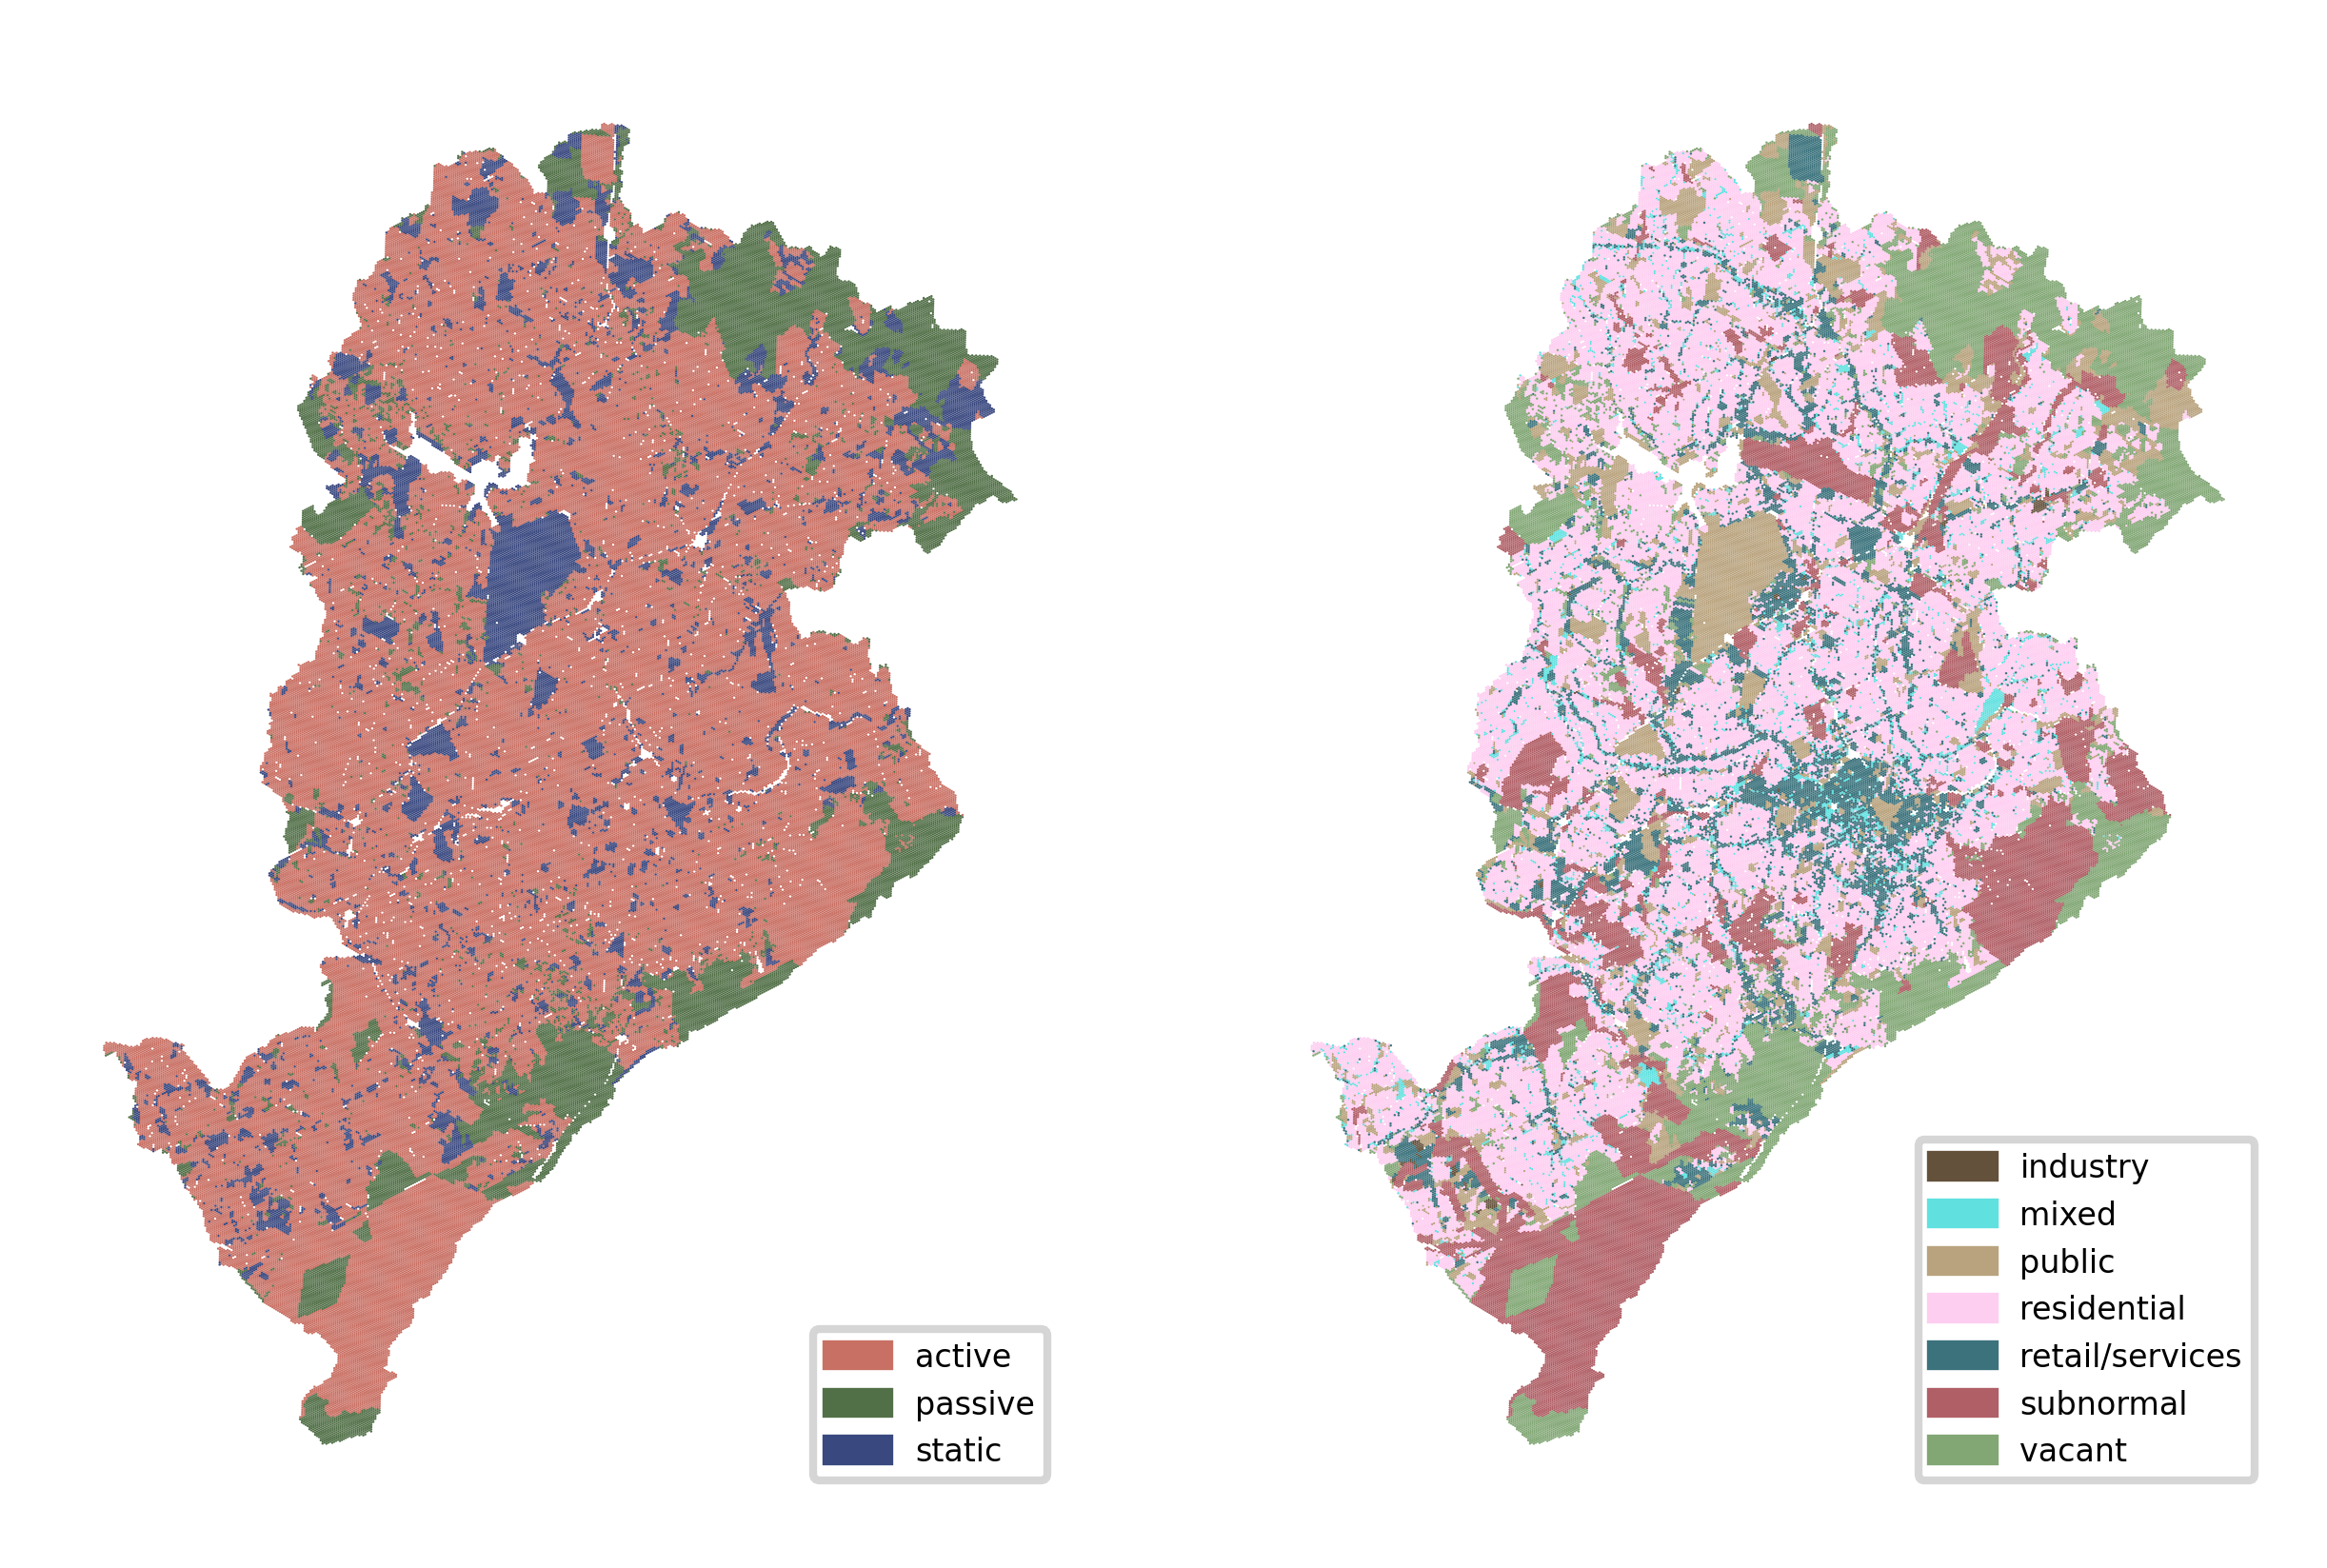

In [28]:
fig,axes = plt.subplots(ncols=2, dpi=300, figsize=(5, 8))
ax1,ax2 = axes


type_palette = {'active': '#C97064',
                'static': '#39487F',
                'passive': '#527048',}
plot_land_uses(hex_,
               'type',
               type_palette,
               ax1,)


category_palette = {'residential': '#FECEF1',
                    'subnormal': '#B05F66',
                    'retail/services': '#3B727C',
                    'mixed': '#60E1E0',
                    'public': '#B9A37E',
                    'industry': '#64513B',
                    'vacant': '#82A775',}
plot_land_uses(hex_,
               'category',
               category_palette,
               ax2,)

# Land Use Maps for 2011

data dource: provided by Prodabel directly

These have been made with a methodology similar to that of 2017 data

In [29]:
path = (db_folder
        / 'beaga'
        / 'tipologia_uso_ocupacao'
        / 'uso_ocup_2011.zip')
land_uses = get_geodata(path)
land_uses = land_uses.explode()
land_uses.reset_index(drop=True, inplace=True)

new_names = {'sigla_uso': 'type', 'descr_ocup': 'category'}
land_uses.rename(columns=new_names, inplace=True)

to_keep = ['type', 'category', 'geometry']
land_uses = land_uses.reindex(columns=to_keep)

del new_names, to_keep

In [30]:
land_uses.head(3)

type       category                                           geometry
0  IDT  indeterminado  POLYGON ((608635.662 7797679.421, 608653.967 7...
1  IDT  indeterminado  POLYGON ((604553.072 7796817.602, 604554.177 7...
2  IDT  indeterminado  POLYGON ((604594.904 7796888.038, 604626.510 7...

In [31]:
print(land_uses.crs)

epsg:31983


In [32]:
number_of_parcels = len(land_uses)

land_uses['type'].value_counts() / number_of_parcels * 100

RES     61.322360
NUL     12.052835
NRES     6.875683
IND      6.547383
LV       6.496853
MIS      4.821371
IDT      1.883514
Name: type, dtype: float64

In [33]:
land_uses.category.value_counts() / number_of_parcels * 100

casa unifamiliar                                 55.985343
nulo                                             12.052835
lote vago                                         6.496853
edificações em LV                                 5.546526
edifício                                          4.723856
casa / sobrado                                    4.241896
loja ou conjunto de lojas                         3.000502
galpão                                            2.841228
indeterminado                                     1.883514
ZEIS-1                                            1.000857
edifício residencial e comércio e/ou serviços     0.579475
conjunto multifamiliar vertical                   0.481073
edifício de uso comercial e/ou de serviços        0.450932
instituição de ensino                             0.291363
conjunto multifamiliar horizontal                 0.132088
loja em edifício / galeria                        0.062646
instituição religiosa                             0.0537

Again, it is self-evident where to put some of the land use categories. Contrarily, the folowwing require a somewhat in-depth analysis:

- ***'nulo'*** seem to be a category akin to 2017's ***'sem informacao'***: they are close in number of parcels and are not given any specific category because there's no detailed information about them in the treasury's registry. Hence, 'nulo' is going to be classified in the same way as 'sem informacao' was previously. The difference being that I'll now use the 2015 urban footrpint. Preferably the anacronism should be smaller or, ideally, non existent. But at the time of writing I could not find any data that was less than four years apart. Alternatively, there was the 2007 footprint, but that probably does not include some possible sprawls that happened from 2007 to 2015.

- ***edificações em LV*** are land parcels that do not yet have a consolidated land use class because that only happens when the real estate receives a certificate of occupancy. Also obviuosly uncertain is the category ***indeterminado***. Hence, given the lack enough information that could enable a proper classification, the two categories are assumed to be residential. The rationale here being the same as the one used for ***'edificacao sem tipologia especificada'***, which is present in the 2017 data.

- As with 2017 data, ***galpao*** is placed under retail/services.

- ***ZEIS-1*** are those parcels that explicitly belong to subnormal agglomerates

This time the function *_reclassify_with_scrutiny()* is useless because type attribute provides no useful information that enables a more precise category disaggregation.

In [34]:
regrouping_2011 = {
    'active': {
        'residential': ['casa unifamiliar',
                        'edificações em LV', 
                        'edifício',
                        'indeterminado',
                        'conjunto multifamiliar vertical',
                        'conjunto multifamiliar horizontal',],
        
        'subnormal': ['ZEIS-1',],
        
        'retail/services': ['loja ou conjunto de lojas',
                            'galpão',
                            'edifício de uso comercial e/ou de serviços',
                            'loja em edifício / galeria',
                            'galeria / mini-shopping de bairro',
                            'shopping',
                            'apart hotel',],
        # TO DO: settle approach towards mixed uses
        'mixed': ['casa / sobrado',
                  'edifício residencial e comércio e/ou serviços',]
                },

     'passive': { 
         'vacant': ['lote vago',]
                 },

     'static': {
         'industry': ['indústria',],
         
         'public': ['instituição de ensino',
                    'instituição religiosa',
                    'equipamento de saúde',
                    'clubes esportivos e sociais',
                    'parques',
                    'cemitério',
                    'estação de transporte coletivo',],
               }
}

In [35]:
reclassify_land_uses(land_uses,
                     regrouping_2011,)

In [36]:
reclassify_untaxed_parcels(land_uses,
                           footprint_2018,
                           subnormal,
                           'nulo',)

In [37]:
land_uses['type'].value_counts() / number_of_parcels * 100

active     86.029373
passive     7.268402
static      6.702225
Name: type, dtype: float64

In [38]:
land_uses.category.value_counts() / number_of_parcels * 100

residential        66.619781
subnormal           8.307674
vacant              7.268402
public              6.672380
retail/services     6.349399
mixed               4.752519
industry            0.029845
Name: category, dtype: float64

In [39]:
hex_land_uses = input_uses_into_hex(land_uses, hexagons)

hex_ = hexagons.merge(hex_land_uses,
                      how='inner',
                      left_index=True,
                      right_index=True,)

hex_.to_file(path_to_hexes, layer='2011', driver='GPKG')

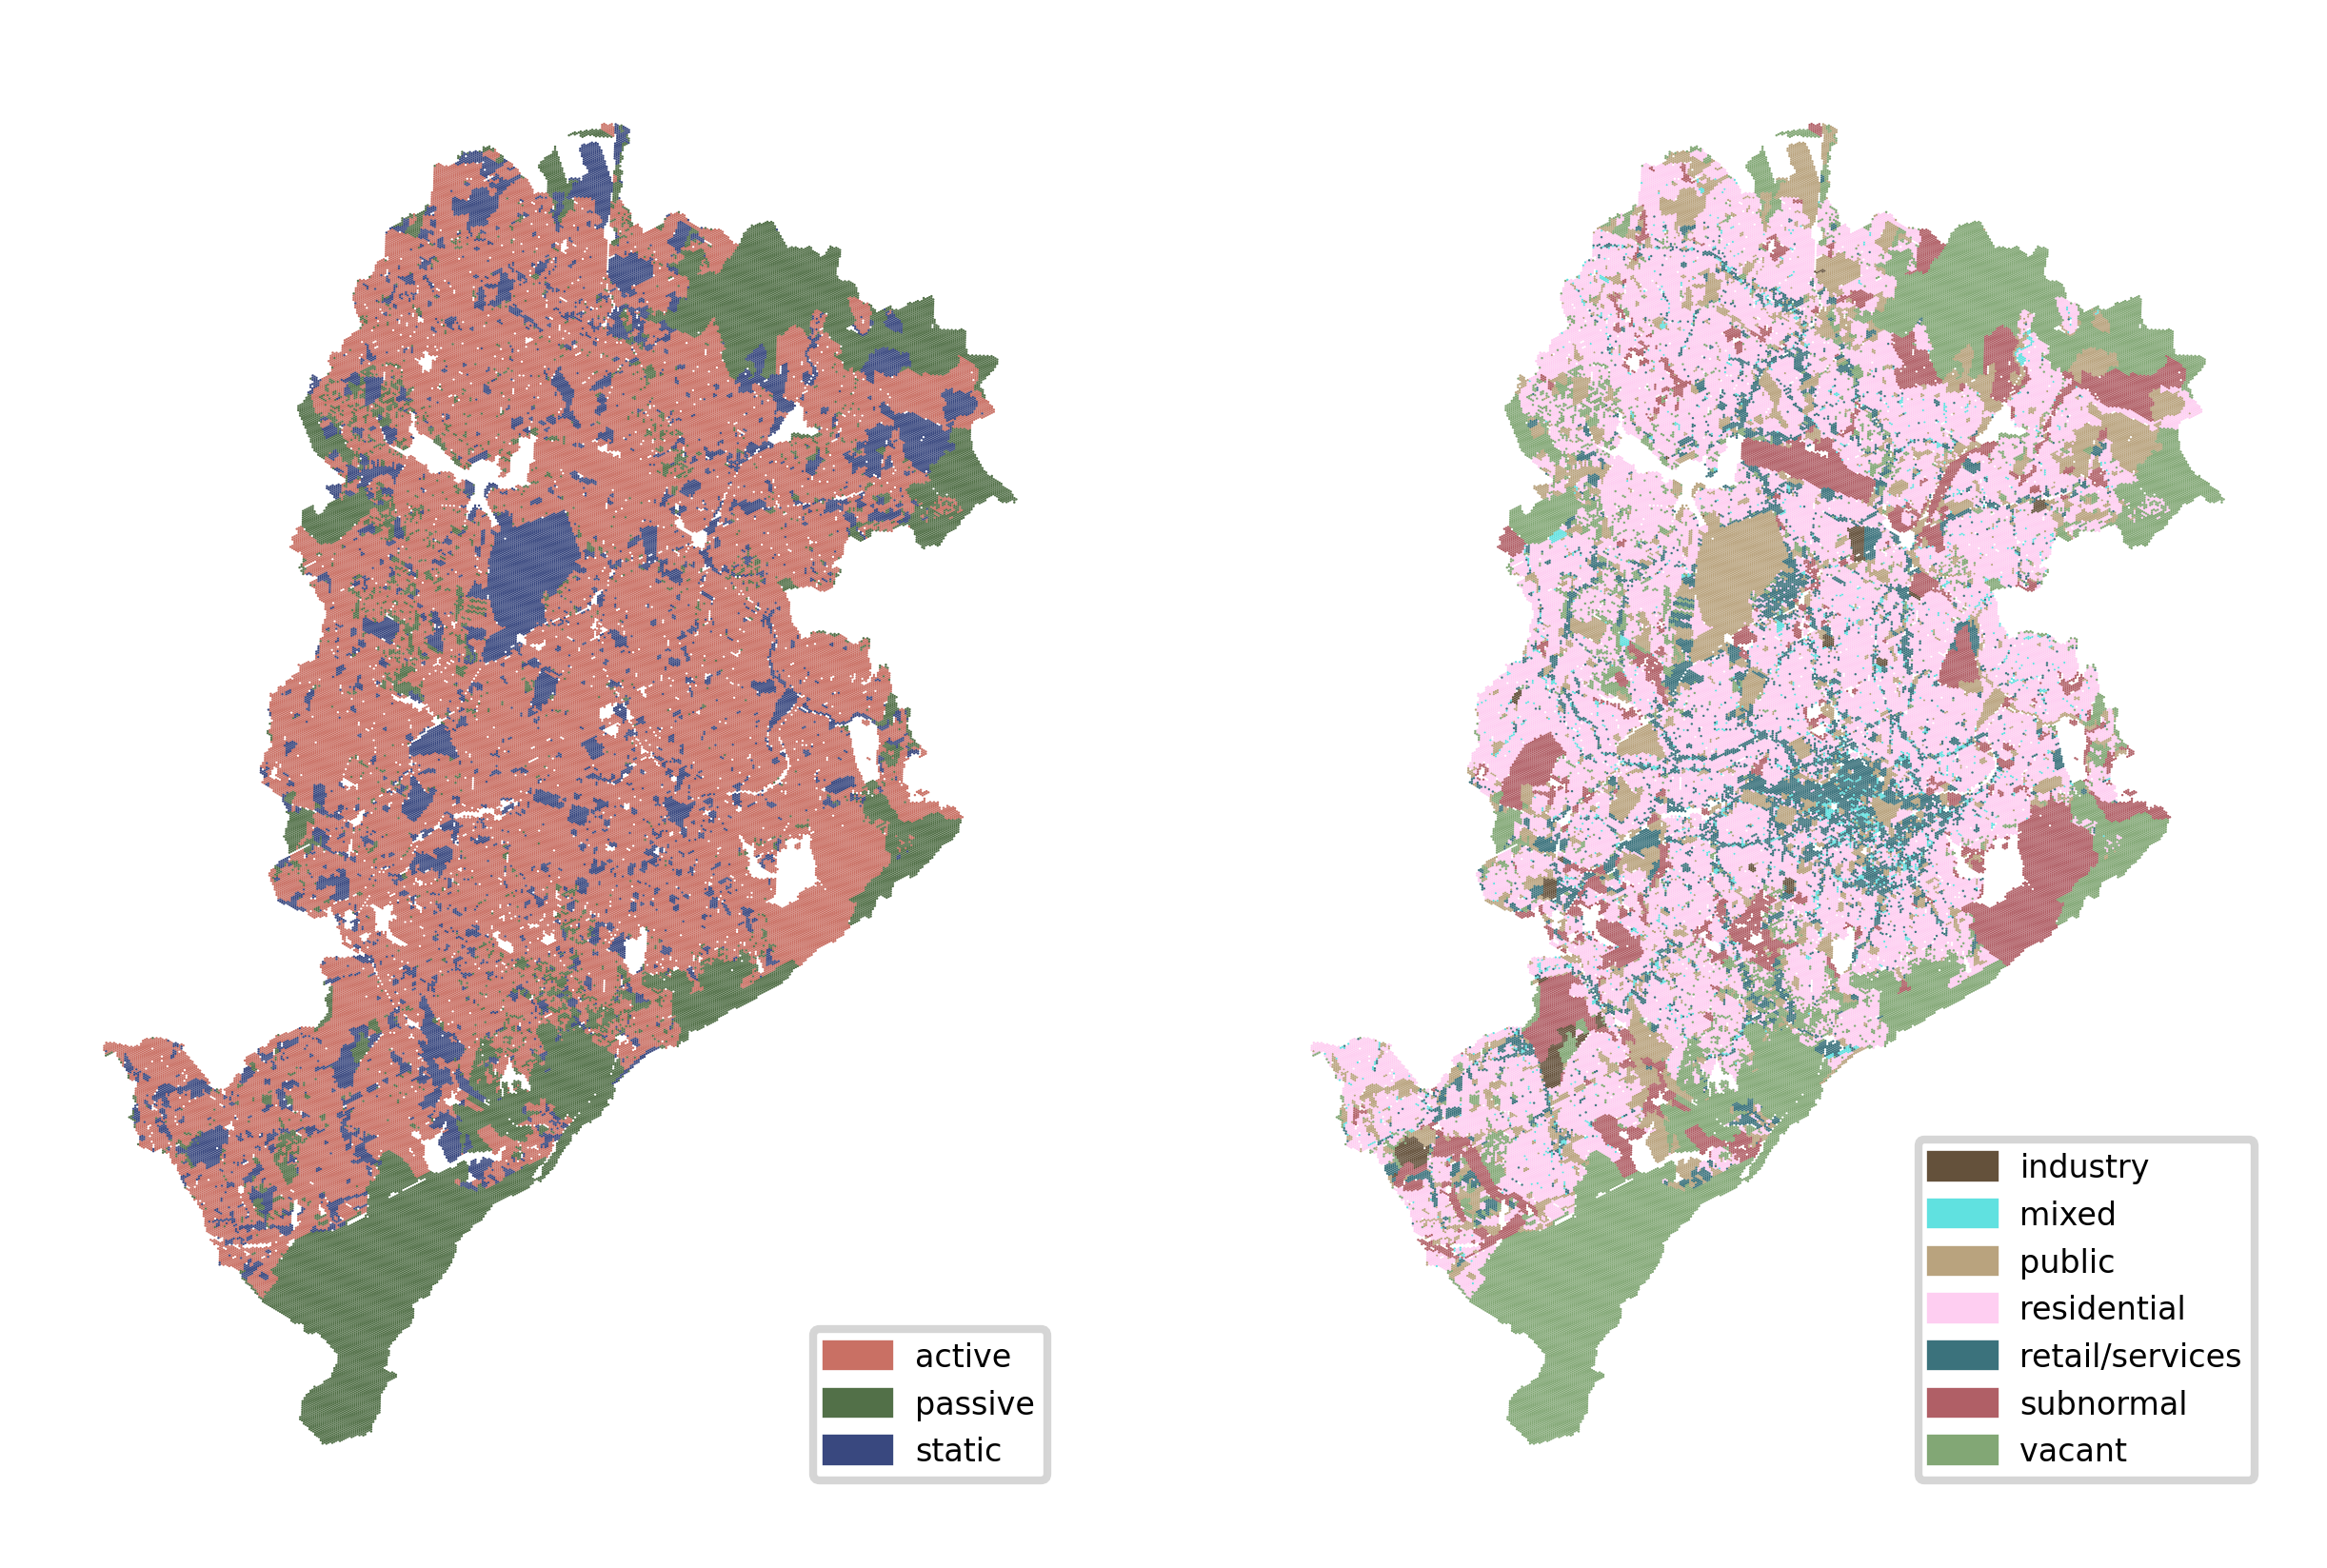

In [40]:
fig,axes = plt.subplots(ncols=2, dpi=300, figsize=(5, 8))
ax1,ax2 = axes

plot_land_uses(hex_,
               'type',
               type_palette,
               ax1,)

plot_land_uses(hex_,
               'category',
               category_palette,
               ax2,)

# Land Use Maps for 2018

data dource: provided by Prodabel directly

These have been made with a methodology similar to that of 2017 data

In [42]:
path = (db_folder
        / 'beaga'
        / 'tipologia_uso_ocupacao'
        / 'uso_ocup_2018.zip')
land_uses = get_geodata(path)
land_uses.head()

OBJECTID_1  Join_Count  TARGET_FID  OBJECTID      NULOTCTM  SUM_AP  SUM_BA  \
0           1           1           1         1  110770000025     0.0     0.0   
1           2           0           2         2  010003100175     0.0     0.0   
2           3           0           3         3  010002900270     0.0     0.0   
3           4           0           4         4  010017300260     0.0     0.0   
4           5           0           5         5  010017300040     0.0     0.0   

   SUM_AC  SUM_GP  SUM_SL  ...                  USO_ATIV    NULOTCTM_3  \
0     0.0     0.0     0.0  ...            SEM INFORMACAO  110770000025   
1     0.0     0.0     0.0  ...  EDIFICIO NAO RESIDENCIAL          None   
2     0.0     0.0     0.0  ...  EDIFICIO NAO RESIDENCIAL          None   
3     0.0     0.0     4.0  ...  EDIFICIO NAO RESIDENCIAL          None   
4     0.0     0.0     0.0  ...  EDIFICIO NAO RESIDENCIAL          None   

   Shape_Le_3  Shape_Ar_2  ZEIS  Shape_Le_4  Shape_Ar_3        AREA  \
0   40.586679   98.853466  ZEIS   46.561508  150.012255  150.012255   
1    0.000000    0.000000  None   93.124165  428.474499  428.474499   
2    0.000000    0.000000  None  131.014502  716.783210  716.783210   
3    0.000000    0.000000  None   51.926533  163.500368  163.500368   
4    0.000000    0.000000  None   92.298098  270.888301  270.888301   

                 USO_AT_REV                                           geometry  
0            SEM INFORMACAO  POLYGON ((606445.950 7790020.185, 606445.035 7...  
1  EDIFICIO NAO RESIDENCIAL  POLYGON ((611192.563 7794833.815, 611183.369 7...  
2  EDIFICIO NAO RESIDENCIAL  POLYGON ((611268.260 7794889.734, 611268.079 7...  
3  EDIFICIO NAO RESIDENCIAL  POLYGON ((611284.736 7794965.178, 611283.565 7...  
4  EDIFICIO NAO RESIDENCIAL  POLYGON ((611283.573 7794966.578, 611273.991 7...  

[5 rows x 87 columns]

In [41]:
land_uses = land_uses.explode()
land_uses.reset_index(drop=True, inplace=True)

AttributeError: 'NoneType' object has no attribute 'type'

In [ ]:
new_names = {'sigla_uso': 'type', 'descr_ocup': 'category'}
land_uses.rename(columns=new_names, inplace=True)

to_keep = ['type', 'category', 'geometry']
land_uses = land_uses.reindex(columns=to_keep)

del new_names, to_keep